# Training

Is the play will paly longer than 6 months? 

Current subsciprtion model has three types, 1 month, 3 months and 6 months. 

Find players the most likely play less than 6 month and send promotion email

In [29]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, accuracy_score, roc_curve, RocCurveDisplay, mean_absolute_error

from interpret import set_visualize_provider
from interpret.provider import InlineProvider

set_visualize_provider(InlineProvider())

In [30]:
wow_players = pd.read_parquet("./data/play_recordes.parquet").reset_index().drop("char", axis=1)
wow_players.head()

,race,zone,numOfJoinedGuild,charclass,level,playcount,start_month,start_level,playduration
0,Orc,38,2,Hunter,63.127588,593,1,54,12
1,Orc,43,2,Hunter,70.000000,1504,1,70,6
2,Orc,31,1,Hunter,50.602446,550,7,29,5
3,Orc,24,3,Rogue,69.983255,1710,1,69,12
4,Orc,50,2,Hunter,70.000000,863,1,70,12


Remove 'Death Knight' class and level lower than 20 because

- Death Knight is released on October, so the maximum preiod of the game play for the charcter can't be long than two month
- Level 20 or lower play game for free

In [31]:
wow_players = wow_players.query("charclass != 'Death Knight' and level > 20")

Add column to indicate players who play the game less than 6 months for classification


In [32]:
wow_players_cls = wow_players.copy()
wow_players_cls["less6m"] = wow_players["playduration"].apply(lambda x: 1 if x < 7 else 0)
wow_players_cls.head()

,race,zone,numOfJoinedGuild,charclass,level,playcount,start_month,start_level,playduration,less6m
0,Orc,38,2,Hunter,63.127588,593,1,54,12,0
1,Orc,43,2,Hunter,70.000000,1504,1,70,6,1
2,Orc,31,1,Hunter,50.602446,550,7,29,5,1
3,Orc,24,3,Rogue,69.983255,1710,1,69,12,0
4,Orc,50,2,Hunter,70.000000,863,1,70,12,0


Players who play the game less than 6 months are 57.8 % of the population, 42.2% player longer than 6 months

<AxesSubplot:ylabel='less6m'>

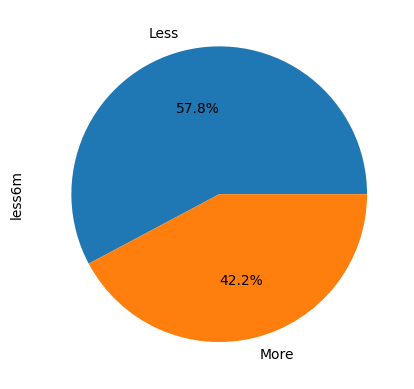

In [33]:
wow_players_cls["less6m"].value_counts().plot.pie(autopct="%.1f%%", labels=["Less","More"],labeldistance=1.12)

Drop 'playduration' column for training

In [34]:
df = wow_players_cls.drop("playduration", axis=1)
df.head()

,race,zone,numOfJoinedGuild,charclass,level,playcount,start_month,start_level,less6m
0,Orc,38,2,Hunter,63.127588,593,1,54,0
1,Orc,43,2,Hunter,70.000000,1504,1,70,1
2,Orc,31,1,Hunter,50.602446,550,7,29,1
3,Orc,24,3,Rogue,69.983255,1710,1,69,0
4,Orc,50,2,Hunter,70.000000,863,1,70,0


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8618 entries, 0 to 29724
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   race              8618 non-null   object 
 1   zone              8618 non-null   int64  
 2   numOfJoinedGuild  8618 non-null   int64  
 3   charclass         8618 non-null   object 
 4   level             8618 non-null   float64
 5   playcount         8618 non-null   int64  
 6   start_month       8618 non-null   int64  
 7   start_level       8618 non-null   int64  
 8   less6m            8618 non-null   int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 673.3+ KB


In [36]:
# col_transform = ColumnTransformer([
#     ("ohe1", OneHotEncoder( drop="if_binary"), ["race"]),
#     ("ohe2", OneHotEncoder( drop="if_binary"), ["charclass"]),
#     ("std_zone", StandardScaler(), ["zone"]),
#     ("std_lv", StandardScaler(), ["level"]),
#     ("std_startlv", StandardScaler(), ["start_level"]),
#     ("str_playcnt", StandardScaler(), ["playcount"])
# ])

col_transform = ColumnTransformer([
    ("ohe1", OneHotEncoder( drop="if_binary"), ["race"]),
    ("ohe2", OneHotEncoder( drop="if_binary"), ["charclass"]),
    ("std_zone", StandardScaler(), ["zone"]),
    ("poly_lv", PolynomialFeatures(), ["level"]),
    ("startlv", PolynomialFeatures(), ["start_level"]),
    ("playcnt", PolynomialFeatures(), ["playcount"])
])

In [37]:
label = "less6m"
X = df.drop(label, axis=1)
y = df[label]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [38]:
def train_model(name, estimator, X_train, y_train, X_test, y_test):
    model = Pipeline([
        ("transformer", col_transform),
        ("estimator", estimator)
    ])
    start_time = time.time_ns()
    model.fit(X_train, y_train)
    duration = (time.time_ns() - start_time)/1000000000

    y_pred = model.predict(X_test)
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc = roc_curve(y_test, y_pred)

    dis = RocCurveDisplay.from_predictions(y_test, y_pred)
    dis.figure_.suptitle(f"{name} ROC Curve")
    dis.figure_.savefig(f"./images/{name}_roc_curve.png")
    
    return model, score_train, score_test, precision, recall, roc, dis, duration

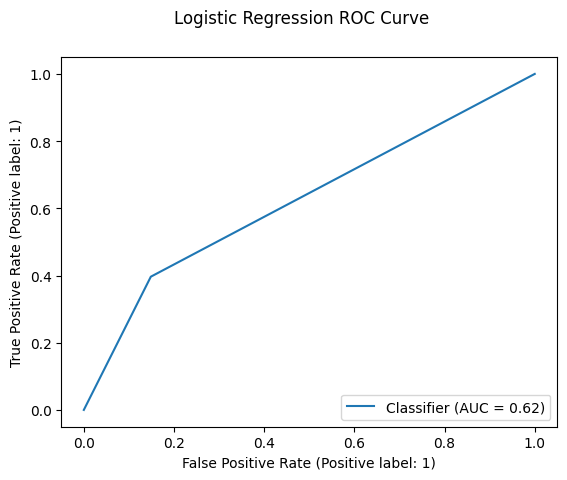

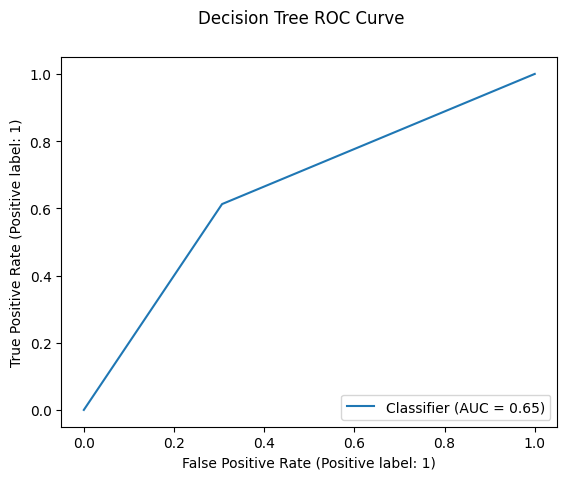

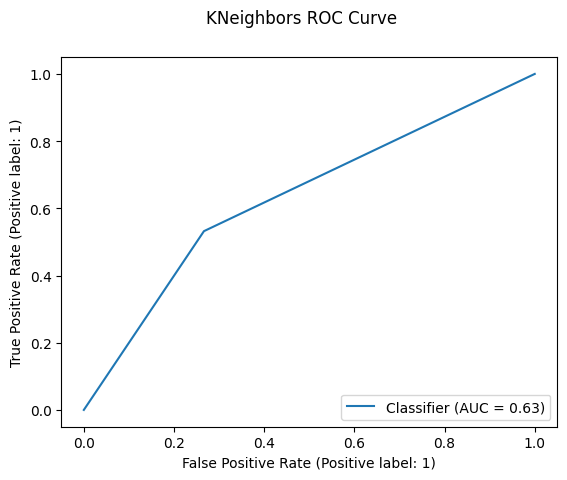

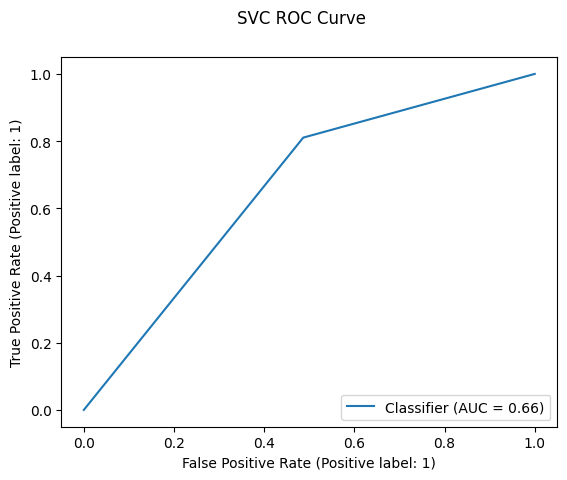

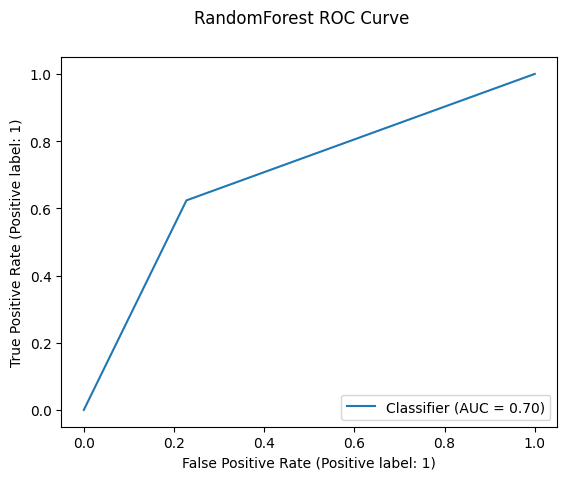

In [39]:
trained_models = []
train_scores = []
test_scores = []
precisions = []
recalls = []
rocs = []
displays = []
durations = []


estimators = [LogisticRegression(), DecisionTreeClassifier(), KNeighborsClassifier(), SVC(), RandomForestClassifier()]
estimator_names = ["Logistic Regression", "Decision Tree", "KNeighbors", "SVC", "RandomForest"]

for i, estimator in enumerate(estimators):
    model, score_train, score_test, precision, recall, roc, dis, duration = train_model(estimator_names[i], estimator, X_train, y_train, X_test, y_test)
    trained_models.append(model)
    train_scores.append(score_train)
    test_scores.append(score_test)
    precisions.append(precision)
    recalls.append(recall)
    rocs.append(roc)
    displays.append(dis)
    durations.append(duration)


In [40]:
results = {"estimator_name": estimator_names, "duration":durations ,"score_train": train_scores, "score_test": test_scores, "precision":precisions, "recall":recalls}
results_df = pd.DataFrame(results).set_index("estimator_name")
results_df

,duration,score_train,score_test,precision,recall
estimator_name,,,,,
Logistic Regression,0.056308,0.672248,0.659319,0.661069,0.396520
Decision Tree,0.045439,0.993700,0.659319,0.593611,0.612637
KNeighbors,0.007170,0.773707,0.648492,0.593463,0.532051
SVC,1.273886,0.636771,0.638824,0.549007,0.810440
RandomForest,0.539472,0.993700,0.709590,0.666993,0.623626


In [41]:
param_grid = {
    'estimator__penalty': ['l1', 'l2'],
    'estimator__C': [0.1, 1, 10, 100],
    'estimator__solver': ['liblinear', 'saga']
}

lr = Pipeline([
        ("transformer", col_transform),
        ("estimator", LogisticRegression())
    ])

grid_search = GridSearchCV(lr, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")

# Evaluate the best model on the test data
best_lr = grid_search.best_estimator_
print(f"Test set accuracy: {best_lr.score(X_test, y_test)}")

Best hyperparameters: {'estimator__C': 1, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}
Test set accuracy: 0.705723124516628


In [42]:
param_grid = {
    'estimator__n_estimators': [10, 50, 100, 200],
    'estimator__max_depth': [None, 2, 4, 6],
    'estimator__min_samples_split': [2, 4, 6],
    'estimator__min_samples_leaf': [1, 2, 3],
    'estimator__max_features': ['auto', 'sqrt', 'log2']
}

rfc = Pipeline([
        ("transformer", col_transform),
        ("estimator", RandomForestClassifier())
    ])

grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")

# Evaluate the best model on the test data
best_rfc = grid_search.best_estimator_
print(f"Test set accuracy: {best_rfc.score(X_test, y_test)}")

c:\Users\hyssh\Anaconda3\envs\pcmlai\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



Best hyperparameters: {'estimator__max_depth': None, 'estimator__max_features': 'auto', 'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 4, 'estimator__n_estimators': 100}
Test set accuracy: 0.7235112142304718


## End of notebook

SVC takes more than hours, the job didn't finish

In [14]:
# param_grid = {
#     'estimator__C': [0.1, 1, 10],
#     'estimator__gamma': [0.1, 1, 10],
#     'estimator__kernel': ['linear', 'rbf', 'poly']
# }

# svm = Pipeline([
#         ("transformer", col_transform),
#         ("estimator", SVC())
#     ])

# grid_search_svm = GridSearchCV(svm, param_grid=param_grid, cv=5, n_jobs=-1)

# # Fit the GridSearchCV object to the training data
# grid_search_svm.fit(X_train, y_train)

# # Print the best hyperparameters
# print(f"Best hyperparameters: {grid_search_svm.best_params_}")

# # Evaluate the best model on the test data
# best_svm = grid_search_svm.best_estimator_
# print(f"Test set accuracy: {best_svm.score(X_test, y_test)}")

ML Interpret test

In [ ]:
from interpret.glassbox import LogisticRegression as glasslr
from interpret import show

Xt = col_transform.fit_transform(X)

Xt_train, Xt_test, y_train, y_test = train_test_split(Xt, y, test_size=0.3, stratify=y)

lr = glasslr()

Xt_train = pd.DataFrame(Xt_train, columns=col_transform.get_feature_names_out())
Xt_test = pd.DataFrame(Xt_test, columns=col_transform.get_feature_names_out())

lr.fit(Xt_train, y_train)

lr_global = lr.explain_global()
show(lr_global)

In [ ]:
lr_local = lr.explain_local(Xt_test[:10], y_test[:10])
show(lr_local)

Random Forest Regressor

In [ ]:
regressor = RandomForestRegressor(n_estimators=300)
regressor.fit(Xt_train, y_train)
regressor.score(Xt_test, y_test)

In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

ebm = ExplainableBoostingClassifier()
ebm.fit(Xt_train, y_train)

ebm_global = ebm.explain_global()
show(ebm_global)

ebm_local = ebm.explain_local(Xt_test[:5], y_test[:5])
show(ebm_local)

## Predict playduration (month)

In [20]:
wow_players = wow_players.query("charclass != 'Death Knight' and level > 20")
wow_players_reg = wow_players.copy()

label = "playduration"
X = wow_players_reg.drop(label, axis=1)
y = wow_players_reg[label]

X = col_transform.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [ ]:
lrg = LinearRegression()
lrg.fit(X_train, y_train)
lrg.score(X_test, y_test)

In [ ]:
preds = lrg.predict(X_test[:100])
plt.scatter(preds, y_test[:100])
plt.plot(range(0,13),range(0,13))

In [ ]:
mean_absolute_error(preds, y_test[:100])

In [ ]:
from interpret.glassbox import LinearRegression as glasslregeg
from interpret import show


lreg = glasslregeg()

Xt_train = pd.DataFrame(X_train, columns=col_transform.get_feature_names_out())
Xt_test = pd.DataFrame(X_test, columns=col_transform.get_feature_names_out())

lreg.fit(Xt_train, y_train)

lreg_global = lreg.explain_global()
show(lreg_global)

In [ ]:
lr_local = lreg.explain_local(Xt_test[:10], y_test[:10])
show(lr_local)